# Theory Model of Aircraft

Importing the Header Files

In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt     

Loading the ML Module

In [4]:

# Load the RandomForestRegressor model from the 'scaler.pkl' file
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
# Load the RandomForestRegressor model from the 'ITailModel.pkl' file
with open('ITailModel.pkl', 'rb') as f:
    Tailmodel = pickle.load(f)

Defining the First Block

### Theory Block

In [6]:
# Theory Function for the Flight Dynamics
def dynamics(p, q, r, u, v, w, phi, theta, psi, X, Y, Z, L, M, N):

    # defining the Constants
    m = 0.45
    g = 9.81
    Ix, Iy, Iz = 0.008965, 0.009146, 0.017975
    Ixz = -0.000274

    # Initialize outputs to be calculated
    # Translational accelerations
    u_dot = ((X - (m * g * np.sin(theta))) / m) + (r * v )- (q * w)
    v_dot = ((Y + (m * g * np.sin(phi) * np.cos(theta))) / m) - (r * u) + (p * w)
    w_dot = ((Z + (m * g * np.cos(phi) * np.cos(theta))) / m) - (p * v) + (q * u)

    # Rotational accelerations
    r_dot = (((Ixz / Ix) * (L + ((Iy - Iz) * q * r) + (Ixz * p * q))) +
             (((Ix - Iy) * p * q) - (Ixz * r * q + N))) / (Iz - (Ixz**2 / Ix))
    p_dot = (L + (Ixz * r_dot) + ((Iy - Iz) * q * r) + (Ixz * p * q)) / Ix
    q_dot = (M + (Iz - Ix) * p * r - (Ixz * (p**2 - r**2))) / Iy

    # Angular rates
    phi_dot = p + ((q * np.sin(phi) + r * np.cos(phi)) * np.tan(theta))
    theta_dot = q * np.cos(phi) - r * np.sin(phi)
    psi_dot = (q * np.sin(phi) / np.cos(theta)) + (r * np.cos(phi) / np.cos(theta))

    # Return the calculated translational and rotational rates
    return {
        'u_dot': u_dot, 'v_dot': v_dot, 'w_dot': w_dot,
        'r_dot': r_dot, 'p_dot': p_dot, 'q_dot': q_dot,
        'phi_dot': phi_dot, 'theta_dot': theta_dot, 'psi_dot': psi_dot
    }

Second Block

### Prediction Block ( Lift and Moment data )

In [7]:
def predict(u, theta, time, flapping_period):

    # Normalize time based on flapping period
    normalized_time = time % flapping_period

    # Create a 2D array for the input
    input_data = [flapping_period, u, theta, normalized_time]

    feature_names = ['Flapping Frequency', 'Airspeed', 'Angle Of Attack', 'Normalised Time']


    Inputdata = pd.DataFrame([input_data], columns=feature_names)
    
    # Make prediction using the model
    y_pred = model.predict(Inputdata)
    
    # Extract predicted values
    Lift = y_pred[0][0]
    InducedDrag = y_pred[0][1]  
    PitchingMoment = y_pred[0][2]
    
    # Equating the values
    L = 0  
    M = PitchingMoment  
    N = 0  

    # Equating the values
    X = InducedDrag
    Y = 0
    Z = Lift

    # Return the calculated values
    return X, Y, Z, L, M, N


Rotation Matrix Block

In [8]:
def euler_rotation_matrix(phi, theta, psi, sequence='xyz'):
    """
    Compute the rotation matrix from Euler angles.
    
    Parameters:
    phi, theta, psi : float
        Rotation angles in radians.
    sequence : str
        Rotation sequence. Default is 'xyz'.
    
    Returns:
    numpy.ndarray
        3x3 rotation matrix
    """
    
    # Compute rotation matrices for each axis
    def Rx(angle):
        return np.array([
            [1, 0, 0],
            [0, np.cos(angle), -np.sin(angle)],
            [0, np.sin(angle), np.cos(angle)]
        ])
    
    def Ry(angle):
        return np.array([
            [np.cos(angle), 0, np.sin(angle)],
            [0, 1, 0],
            [-np.sin(angle), 0, np.cos(angle)]
        ])
    
    def Rz(angle):
        return np.array([
            [np.cos(angle), -np.sin(angle), 0],
            [np.sin(angle), np.cos(angle), 0],
            [0, 0, 1]
        ])
    
    # Dictionary to map characters to rotation functions
    rot_map = {'x': Rx, 'y': Ry, 'z': Rz}
    
    # Compute the rotation matrix based on the sequence
    R = np.eye(3)
    for axis, angle in zip(sequence[::-1], [psi, theta, phi][::-1]):
        R = np.dot(rot_map[axis](angle), R)
    
    return R

# Example usage
phi = np.radians(30)    # Roll
theta = np.radians(45)  # Pitch
psi = np.radians(60)    # Yaw

R = euler_rotation_matrix(phi, theta, psi, sequence='xyz')
print("Rotation Matrix:")
print(R)

Rotation Matrix:
[[ 0.61237244 -0.35355339  0.70710678]
 [ 0.78033009  0.12682648 -0.61237244]
 [ 0.12682648  0.9267767   0.35355339]]


AOA Block

In [9]:
def angle_of_attack(phi, theta, psi, V_b_b, V_a_g):
    R= euler_rotation_matrix(phi, theta, psi)
    V_a_b = np.dot(np.transpose(R),V_a_g) # velocity of wind/air in body frame
    V_net = V_b_b - V_a_b
    a_o_a = 0
    if(V_net[2] and V_net[0] > 0):
        a_o_a = np.arctan(V_net[2]/V_net[0]) 
    if(V_net[0]<0):
        return ("neg velocity")
    return a_o_a

Third Block 

### Integration block

In [10]:
def integrate(presentTime, time_step, u_dot, v_dot, w_dot, p_dot, q_dot, r_dot, phi_dot, theta_dot, psi_dot, u, v, w, p, q, r, phi, theta, psi):

    # Integrating the variables and returning them
    
    u_new = u + u_dot * time_step
    v_new = v + v_dot * time_step
    w_new = w + w_dot * time_step

    p_new = p + p_dot * time_step
    q_new = q + q_dot * time_step
    r_new = r + r_dot * time_step

    phi_new = phi + phi_dot * time_step
    theta_new = theta + theta_dot * time_step
    psi_new = psi + psi_dot * time_step

    return u_new, v_new, w_new, p_new, q_new, r_new, phi_new, theta_new, psi_new


Tail Model

In [11]:
def Tail(u, time, flapping_period, PitchingMoment):
    
    # Normalize time based on flapping period
    NormTime = time % flapping_period

    # Create a 2D array for the input
    input_data = [u, NormTime, -PitchingMoment]

    feature_names = [ 'AirSpeed','NormalisedTime', 'PitchingMoment']


    Inputdata = pd.DataFrame([input_data], columns=feature_names)

    # Make prediction using the model
    y_pred = Tailmodel.predict(Inputdata)

    # Extract predicted values
    Lift = y_pred[0][0]
    InducedDrag = y_pred[0][1]
    DeflectionAngle = y_pred[0][2]

    # Equating the values
    L = 0  
    M = -PitchingMoment
    N = 0

    # Equating the values
    X = InducedDrag
    Y = 0
    Z = Lift

    # Return the calculated values
    return X, Y, Z, L, M, N , DeflectionAngle



Main Code

In [12]:
# Main code to run the whole simulation in a loop for each time step

#Function to run the simulation
def simulation(T,t_step, t, u, v, w, phi, theta, psi,p, q, r, V_a_g, flapping_period):
    # Lists to store the results
    u_list = []
    v_list = []
    w_list = []
    phi_list = []
    theta_list = []
    psi_list = []
    p_list = []
    q_list = []
    r_list = []
    Z_list = []
    MT_list = []
    DeflectionAngle_list = []
    aoa_list = []
    time_list = []

    # Initializing the accerlations
    accelerations = {
    'u_dot': 0,
    'v_dot': 0,
    'w_dot': 0,
    'r_dot': 0,
    'p_dot': 0,
    'q_dot': 0,
    'phi_dot': 0,
    'theta_dot': 0,
    'psi_dot': 0
    }   

    # Run the simulation
    while t < T:
        # Calculate the aerodynamic forces and moments
        aoa = angle_of_attack(phi,theta,psi,[u,v,w],V_a_g)
        
        if(aoa == "neg velocity"):                 # to break if body velocity is negative
            print("flight can't fly negative velocity detected")
            break
    
        speed = np.sqrt(u**2 + v**2 + w**2 )
        XM, YM, ZM, LM, MM, NM = predict(speed, aoa, t, flapping_period)
        Z_list.append(ZM)

        # Values from the Tail
        XT, YT, ZT, LT, MT, NT , DeflectionAngle = Tail(speed, t, flapping_period, MM)
        MT_list.append(MT)

        X, Y, Z, L, M, N = XM + XT, YM + YT, ZM + ZT, LM + LT, MM + MT, NM + NT

        # Calculate the accelerations
        accelerations = dynamics(p, q, r, u, v, w, phi, theta, psi, X, Y, Z, L, M, N)

        # Integrate to get new velocities
        u, v, w, p, q, r, phi, theta, psi = integrate(t, t_step, 0, accelerations['v_dot'], accelerations['w_dot'],
                                                    accelerations['p_dot'], accelerations['q_dot'], accelerations['r_dot'],
                                                    accelerations['phi_dot'], accelerations['theta_dot'], accelerations['psi_dot'],
                                                    u, v, w, p, q, r, phi, theta, psi)
        
        # Append the results to the lists
        u_list.append(u)
        v_list.append(v)
        w_list.append(w)
        phi_list.append(phi)
        theta_list.append(theta)
        psi_list.append(psi)
        p_list.append(p)
        q_list.append(q)
        r_list.append(r)
        DeflectionAngle_list.append(DeflectionAngle)
        aoa_list.append(np.rad2deg(aoa))
        time_list.append(t)

        # Update the time
        t += t_step

    # Convert the lists to NumPy arrays
    u_array = np.array(u_list)
    v_array = np.array(v_list)
    w_array = np.array(w_list)
    phi_array = np.array(phi_list)
    theta_array = np.array(theta_list)
    psi_array = np.array(psi_list)
    p_array = np.array(p_list)
    q_array = np.array(q_list)
    r_array = np.array(r_list)
    Z_array = np.array(Z_list)
    DeflectionAngle_array = np.array(DeflectionAngle_list)
    aoa_array = np.array(aoa_list)
    time_array = np.array(time_list)

    # Plot the results
    plt.figure()
    plt.plot(time_array, u_array, label='u')
    plt.plot(time_array, v_array, label='v')
    plt.plot(time_array, w_array, label='w')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(time_array, phi_array, label='phi')
    plt.plot(time_array, theta_array, label='theta')
    plt.plot(time_array, psi_array, label='psi')
    plt.xlabel('Time (s)')
    plt.ylabel('Angles (rad)')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(time_array, p_array, label='p')
    plt.plot(time_array, q_array, label='q')
    plt.plot(time_array, r_array, label='r')
    plt.xlabel('Time (s)')
    plt.ylabel('Angular rates (rad/s)')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.scatter(time_array, Z_array, label='Lift')
    plt.xlabel('Time (s)')
    plt.ylabel('Lift (N)')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(time_array, DeflectionAngle_array, label='Tail_def')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (deg)')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(time_array, aoa_array, label='aoa')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (deg)')
    plt.legend()
    plt.grid()
    plt.show()

    # Save the results to a CSV file
    df = pd.DataFrame({
        'Time': time_array,
        'u': u_array,
        'v': v_array,
        'w': w_array,
        'phi': phi_array,
        'theta': theta_array,
        'psi': psi_array,
        'p': p_array,
        'q': q_array,
        'r': r_array
    })
    df.to_csv('results.csv', index=False)

    print("Simulation completed and results saved to 'results.csv' file.")



Function Call to run the whole Simulation for the given Initail Conditions

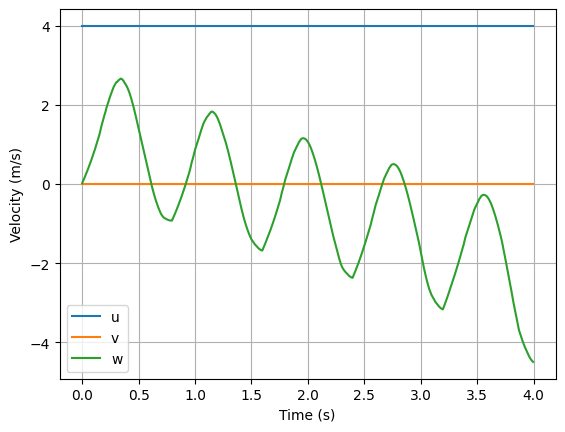

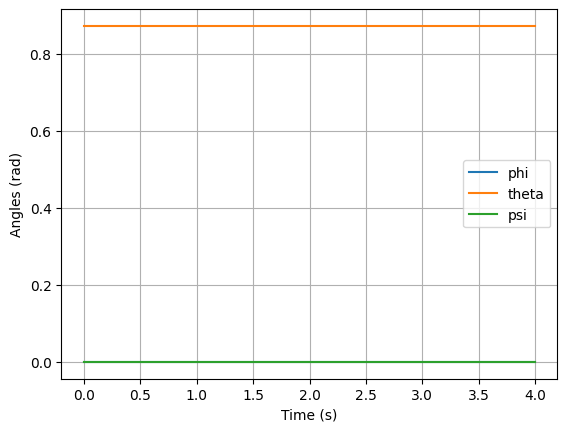

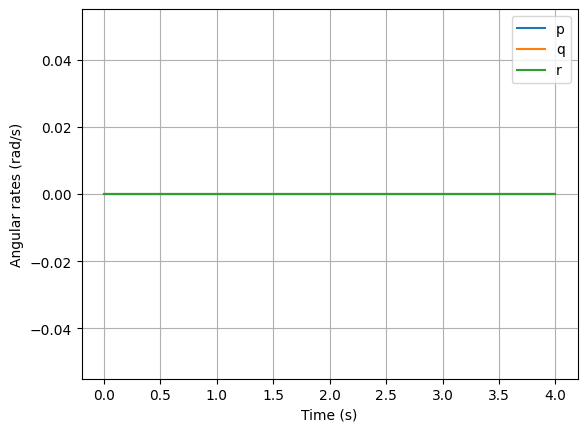

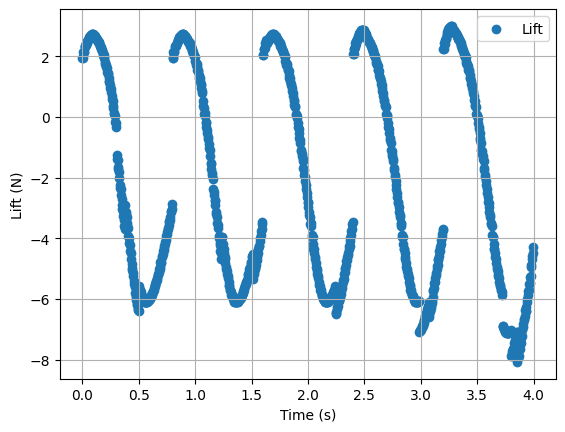

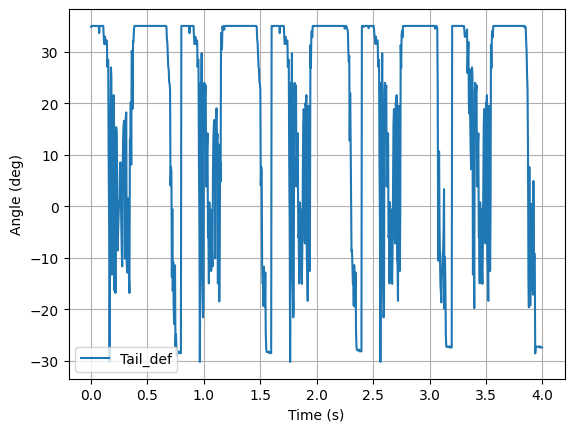

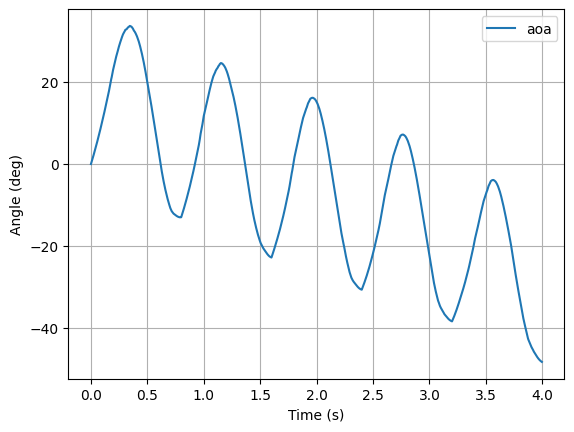

Simulation completed and results saved to 'results.csv' file.


In [19]:
# Simulation paramters
#_______________________________________________________________________________________________________________________ 
T = 4 # Total time for the simulation 
t_step = T / 1000 # Time step for the simulation
t = 0 # Initial time
#_______________________________________________________________________________________________________________________

# Initial conditions
#_______________________________________________________________________________________________________________________
theta_deg = 50
theta= np.deg2rad(theta_deg)
V_a_g = [0, 0, 0] # velocity of air in ground frame
speed = 4
u = speed
v = 0
w = 0
phi = 0
psi = 0
p = 0
q = 0
r = 0
flapping_period = 0.8
#_______________________________________________________________________________________________________________________

# funcion call
simulation(T,t_step, t, u, v, w, phi, theta, psi,p, q, r, V_a_g, flapping_period)